In [1]:
# !pip install numpy==1.19.5
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

from sklearn.model_selection import train_test_split

C:\Users\GamePC\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\GamePC\miniconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\GamePC\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def import_data():
    """
    Import data and split into features and labels
    """
    data = pd.read_csv('data_kia.csv').values
    x_data = data[:, :51]
    y_data = data[:, 52]
    return x_data, y_data

data, labels = import_data()
data

array([[268.8, 0.0, 5.2, ..., -8.8, 0, -3.4],
       [243.2, 0.0, 6.1, ..., -0.2, 0, -3.6],
       [217.6, 0.0, 5.2, ..., -0.2, 0, -3.6],
       ...,
       [345.6, 0.0, 6.6, ..., 0.0, 0, -13.2],
       [332.8, 0.0, 5.7, ..., 0.0, 0, -13.3],
       [281.6, 0.0, 5.2, ..., -0.1, 0, -13.3]], dtype=object)

In [3]:
def normalize_data(rows):
    max_columns = rows.max(axis=0)
    min_columns = rows.min(axis=0)
    norm_rows = np.empty(rows.shape)
    for i in range(rows.shape[1]):
        for j in range(rows.shape[0]):
            if ((max_columns[i]-min_columns[i])>0):
                norm_rows[j][i] = (rows[j][i] - min_columns[i])/(max_columns[i]-min_columns[i])
            else:
                norm_rows[j][i] = 0
    return norm_rows

normal_data = normalize_data(data)
normal_data


array([[0.02459016, 0.        , 0.052     , ..., 0.07650273, 0.        ,
        0.49030656],
       [0.02224824, 0.        , 0.061     , ..., 0.54644809, 0.        ,
        0.49011556],
       [0.01990632, 0.        , 0.052     , ..., 0.54644809, 0.        ,
        0.49011556],
       ...,
       [0.03161593, 0.        , 0.066     , ..., 0.55737705, 0.        ,
        0.48094738],
       [0.03044496, 0.        , 0.057     , ..., 0.55737705, 0.        ,
        0.48085188],
       [0.02576112, 0.        , 0.052     , ..., 0.55191257, 0.        ,
        0.48085188]])

In [4]:
def onehot_labels(labels, num_labels=10):
    """
    Converts label array to 1-hot encoded vectors
    """

    result = []

    for l in labels:
        label_vector = [0] * num_labels
        index = ord(l) - ord('A')
        label_vector[index] = 1

        result.append(label_vector)

    return np.array(result)

# y_data = tf.convert_to_tensor(onehot_labels(labels), dtype=tf.float64)
y_data = onehot_labels(labels)

y_data

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
def package_data(data, window_size=16):
    result = []
    for i in range(len(data) - window_size):
        result.append(data[i:i + window_size])

    return result
# x_data = tf.convert_to_tensor(package_data(normal_data), dtype=tf.float64)
x_data = package_data(normal_data)
x_data[0].shape

(16, 51)

In [6]:

def add_noise(data, noise_level, std_level):
    noise_map = np.random.rand(data.shape[0], data.shape[1])

    non_noise_indices = np.where(noise_map >= noise_level)
    
    noise = np.random.normal(0, std_level, data.shape)
    noise[non_noise_indices] = 0

    return data + noise

noisy_data = add_noise(data, 0.8, 2.0)
noisy_data 
    


array([[266.863356333081, 1.2189352947351675, 8.669592814511688, ...,
        -8.8, -2.669251917858449, -5.03585301691341],
       [243.45442219123825, 0.7213054443191724, 5.350372436139346, ...,
        -1.8934738184035609, -1.474086183796503, -3.371621673682045],
       [218.09776959199138, -1.5812616835765092, 4.023329164742707, ...,
        -1.4944611989371024, -3.0904128035895186, -3.5753111643388125],
       ...,
       [345.254207561952, 0.6310178784618187, 6.907319355520082, ...,
        1.4591511393193686, -1.6913436683768674, -15.882872536708918],
       [332.8, -0.5631382311984023, 8.528513067846577, ...,
        0.7095852816778879, 0.0, -16.345715328031016],
       [279.44259224275936, 1.3422273398485978, 3.7689105841652917, ...,
        1.7363227102195193, 0.0, -13.595071138509228]], dtype=object)

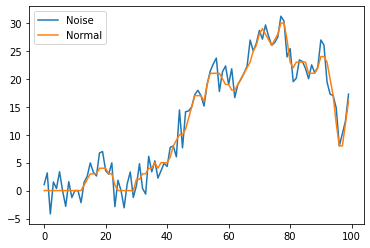

In [7]:
plt.plot(noisy_data[:100, 43])
plt.plot(data[:100, 43])
plt.legend(["Noise", "Normal"])
plt.show()

In [8]:
data_sets = []
std_levels = [0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]
for i in std_levels:
    data_sets.append(normalize_data(add_noise(data, 1, i)))

In [9]:
packaged_data = []
for data_set in data_sets:
    packaged_data.append(np.array(package_data(data_set)))

In [10]:
# create train and test batches
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data[16:], test_size=0.15
)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape), print(x_test.shape)
print(y_train.shape, y_test.shape)

(80209, 16, 51)
(14155, 16, 51)
(80209, 10) (14155, 10)


In [11]:
def create_model(learning_rate=1e-4, window_size=16, num_features=51):
    model = Sequential()
    model.add(LSTM(160, input_shape=(window_size, num_features), return_sequences=True ))
    model.add(LSTM(200, ))

    model.add(Dense(10, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['categorical_crossentropy'])

    return model

In [12]:
model = create_model()
model.fit(x_train, y_train, epochs=1000, batch_size=256)

Epoch 1/1000
314/314 [==============================] - 3s 9ms/step - loss: 1.7456 - categorical_crossentropy: 1.7456
Epoch 2/1000
314/314 [==============================] - 3s 10ms/step - loss: 1.1100 - categorical_crossentropy: 1.1100
Epoch 3/1000
314/314 [==============================] - 3s 9ms/step - loss: 0.9240 - categorical_crossentropy: 0.9240
Epoch 4/1000
314/314 [==============================] - 3s 9ms/step - loss: 0.7899 - categorical_crossentropy: 0.7899
Epoch 5/1000
314/314 [==============================] - 3s 10ms/step - loss: 0.7022 - categorical_crossentropy: 0.7022
Epoch 6/1000
314/314 [==============================] - 3s 10ms/step - loss: 0.6426 - categorical_crossentropy: 0.6426
Epoch 7/1000
314/314 [==============================] - 3s 10ms/step - loss: 0.5863 - categorical_crossentropy: 0.5863
Epoch 8/1000
314/314 [==============================] - 3s 9ms/step - loss: 0.5401 - categorical_crossentropy: 0.5401
Epoch 9/1000
314/314 [==============================

In [13]:
# noisy_test = add_noise(x_test)
predictions = []
for i, p in enumerate(packaged_data):
    print(i)
    predictions.append(model.predict(p[:10000]))


0
1
2
3
4
5
6
7
8
9


In [14]:
percentages = []

for j, prediction in enumerate(predictions):
    correct_count = 0

    for i, p in enumerate(prediction):
        # check if predicted labels is the same as test label
        if np.argmax(p) == np.argmax(y_data[i]):
            correct_count += 1
    
    percentages.append(correct_count/len(prediction))
# print(f"Accuracy: {correct_count} / {len(prediction)} = {correct_count / len(prediction) * 100:.2f}%")

percentages

[0.991, 0.2566, 0.2509, 0.2403, 0.2422, 0.2136, 0.2167, 0.1878, 0.2003, 0.1486]

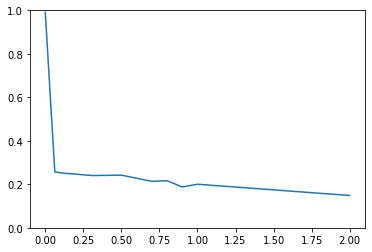

In [15]:
plt.plot(std_levels, percentages)
plt.ylim((0.0, 1.0))
plt.show()

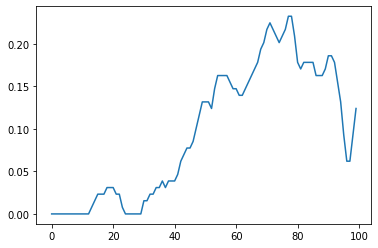

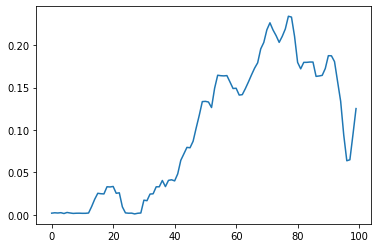

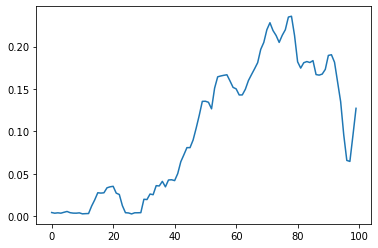

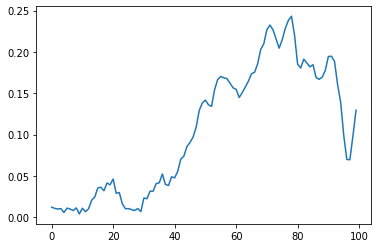

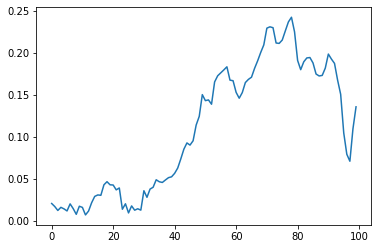

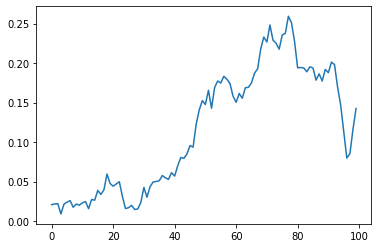

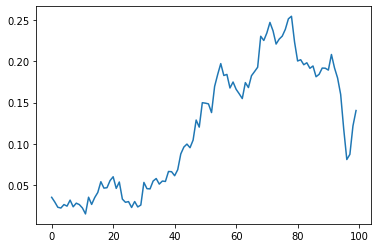

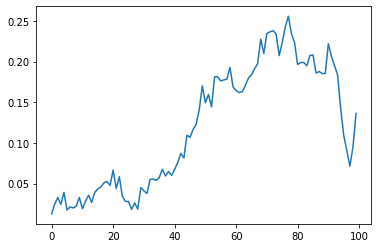

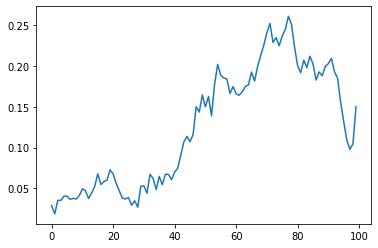

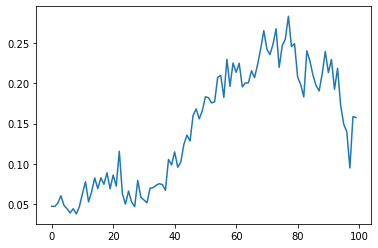

In [16]:
for d in data_sets:
    plt.plot(d[:100, 43])
    plt.show()

In [17]:
model.save("99accuracy.h5")